/Users/nicolasatkins/.conda/envs/Advanced-Algorithmic-Trading/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
logp = -140.85, ||grad|| = 0.0052288: 100%|██████████| 23/23 [00:00<00:00, 2455.68it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:08<00:00, 2610.47draws/s]
The acceptance probability does not match the target. It is 0.8805328428853855, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/nicolasatkins/.conda/envs/Advanced-Algorithmic-Trading/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/nicolasatkins/.conda/envs/Advanced-Algorithmic-Trading/lib/python3.8/site-packages/arviz/pl

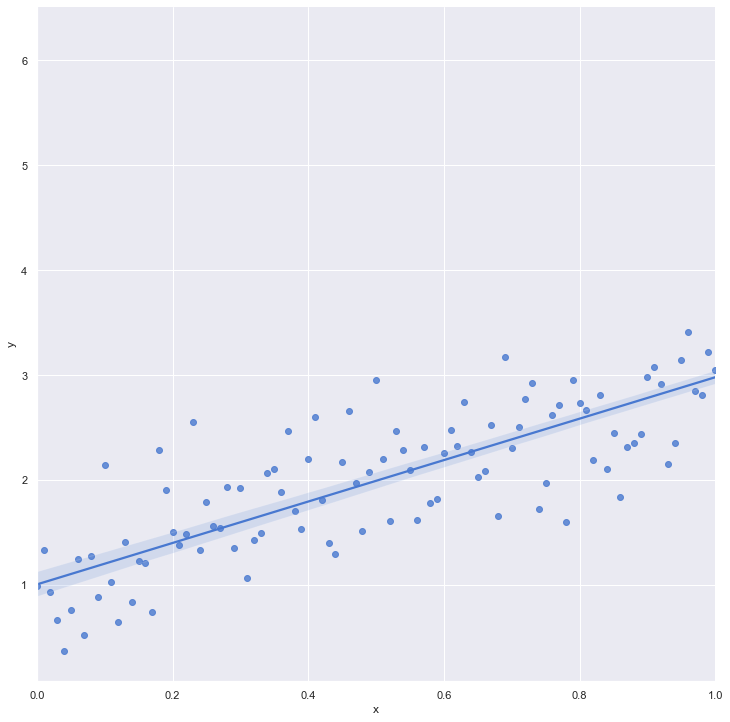

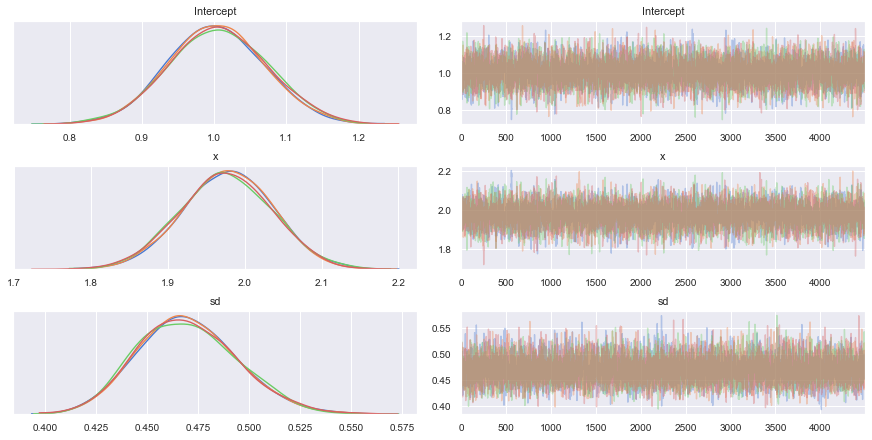

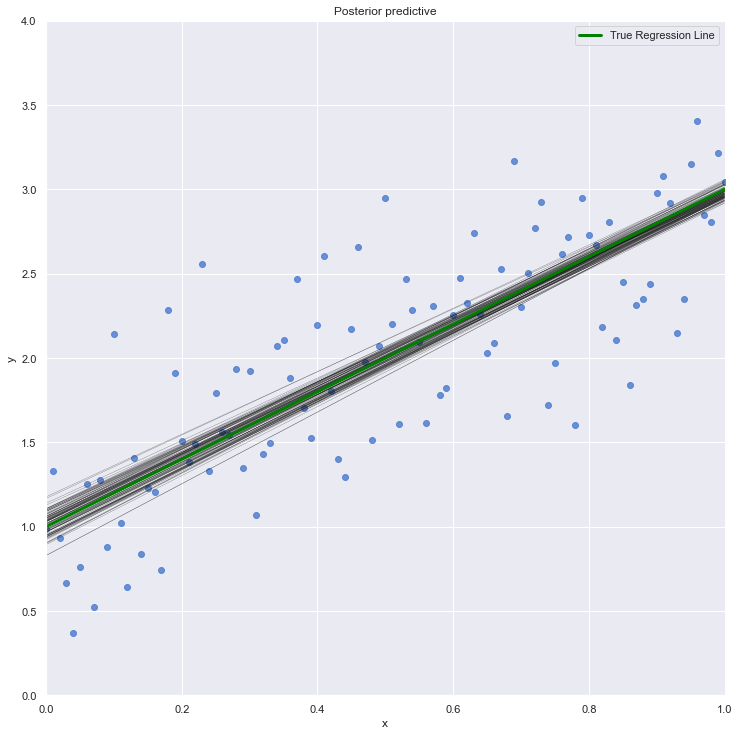

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns


sns.set(style="darkgrid", palette="muted")


def simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq):
    """
    Simulate a random dataset using a noisy
    linear process.

    N: Number of data points to simulate
    beta_0: Intercept
    beta_1: Slope of univariate predictor, X
    """
    # Create a pandas DataFrame with column 'x' containing
    # N uniformly sampled values between 0.0 and 1.0
    df = pd.DataFrame(
        {"x":
            np.random.RandomState(42).choice(list(
                map(
                    lambda x: float(x)/100.0,
                    np.arange(N)
                )), N, replace=False
            )

        }
    )

    # Use a linear model (y ~ beta_0 + beta_1*x + epsilon) to
    # generate a column 'y' of responses based on 'x'
    eps_mean = 0.0
    df["y"] = beta_0 + beta_1*df["x"] + np.random.RandomState(42).normal(
        eps_mean, eps_sigma_sq, N
    )

    return df


def glm_mcmc_inference(df, iterations=5000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression
    model on supplied data.

    df: DataFrame containing the data
    iterations: Number of iterations to carry out MCMC for
    """
    # Use PyMC3 to construct a model context
    basic_model = pm.Model()
    with basic_model:
        # Create the glm using the Patsy model syntax
        # We use a Normal distribution for the likelihood
        pm.glm.GLM.from_formula("y ~ x", df, family=pm.glm.families.Normal())

        # Use Maximum A Posteriori (MAP) optimisation
        # as initial value for MCMC
        start = pm.find_MAP()

        # Use the No-U-Turn Sampler
        step = pm.NUTS()

        # Calculate the trace
        trace = pm.sample(
            iterations, step, start,
            random_seed=42, progressbar=True
        )

    return trace


if __name__ == "__main__":
    # These are our "true" parameters
    beta_0 = 1.0  # Intercept
    beta_1 = 2.0  # Slope

    # Simulate 100 data points, with a variance of 0.5
    N = 200
    eps_sigma_sq = 0.5

    # Simulate the "linear" data using the above parameters
    df = simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq)

    # Plot the data, and a frequentist linear regression fit
    # using the seaborn package
    sns.lmplot(x="x", y="y", data=df, size=10)
    plt.xlim(0.0, 1.0)

    trace = glm_mcmc_inference(df, iterations=5000)
    pm.traceplot(trace[500:])
    plt.show()

    # Plot a sample of posterior regression lines
    sns.lmplot(x="x", y="y", data=df, size=10, fit_reg=False)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 4.0)
    pm.plot_posterior_predictive_glm(trace, samples=100)
    x = np.linspace(0, 1, N)
    y = beta_0 + beta_1*x
    plt.plot(x, y, label="True Regression Line", lw=3., c="green")
    plt.legend(loc=0)
    plt.show()